# Load Data

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
data_path = '/Users/christopherwmurphy/Documents/projects/lhc_olympics/LHC-Olympics-2020/data_processed'

In [3]:
df_bg = pd.read_hdf(os.path.join(data_path, 'processed_eventsLHCO2020backgroundMCPythia.h5'), key='processed')

In [4]:
df_1 = pd.read_hdf(os.path.join(data_path, 'processed_eventsLHCO2020BlackBox1.h5'), key='processed')

# Outlier Detection

In [5]:
od_cols = ['pt_1', 'pt_2', 'sqrt(tau1(2))/tau1(1)_1', 'tau21_1', 'tau32_1', 'tau43_1', 
           'sqrt(tau1(2))/tau1(1)_2', 'tau21_2', 'tau32_2', 'tau43_2', 'mass_1+mass_2', '|mass_1-mass_2|']

Using Principal Component Analysis as my outlier detector, intentionally avoiding using deep learning

In [6]:
from pyod.models.pca import PCA
from sklearn.preprocessing import QuantileTransformer

In [8]:
qt1 = QuantileTransformer()
X_od1 = qt1.fit_transform(df_1[od_cols])
pca_1 = PCA(n_components=11, n_selected_components=1)
pca_1.fit(X_od1)
df_1['pca'] = pca_1.decision_scores_

In [9]:
qt_bg = QuantileTransformer()
X_od_bg = qt_bg.fit_transform(df_bg[od_cols])
pca_bg = PCA(n_components=11, n_selected_components=1)
pca_bg.fit(X_od_bg)
df_1['pca_bg'] = pca_bg.decision_function(X_od1)
df_bg['pca'] = pca_bg.decision_scores_

In [10]:
od_hist_bins = np.arange(1750, 10750, 500)
od_quantiles = [0.0, 0.7, 0.9, 0.97, 0.99]

In [7]:
import sys
sys.path.append('../')
from src.analysis import utils

In [12]:
od_hist_1 = utils.get_histograms(df_1, od_hist_bins, quantiles=od_quantiles)
od_hist_1bg = utils.get_histograms(df_1, od_hist_bins, quantiles=od_quantiles, feature='pca_bg')
od_hist_bg = utils.get_histograms(df_bg, od_hist_bins, quantiles=od_quantiles)

In [8]:
import matplotlib.pyplot as plt

In [9]:
%matplotlib notebook

plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.serif'] = "cm"

In [10]:
image_dir = '/Users/christopherwmurphy/Documents/projects/lhc_olympics/LHC-Olympics-2020/images'

- Points: outlier detector
- Solid lines: novelty detector
- Gray dashed lines: background-only outlier detector

<IPython.core.display.Javascript object>


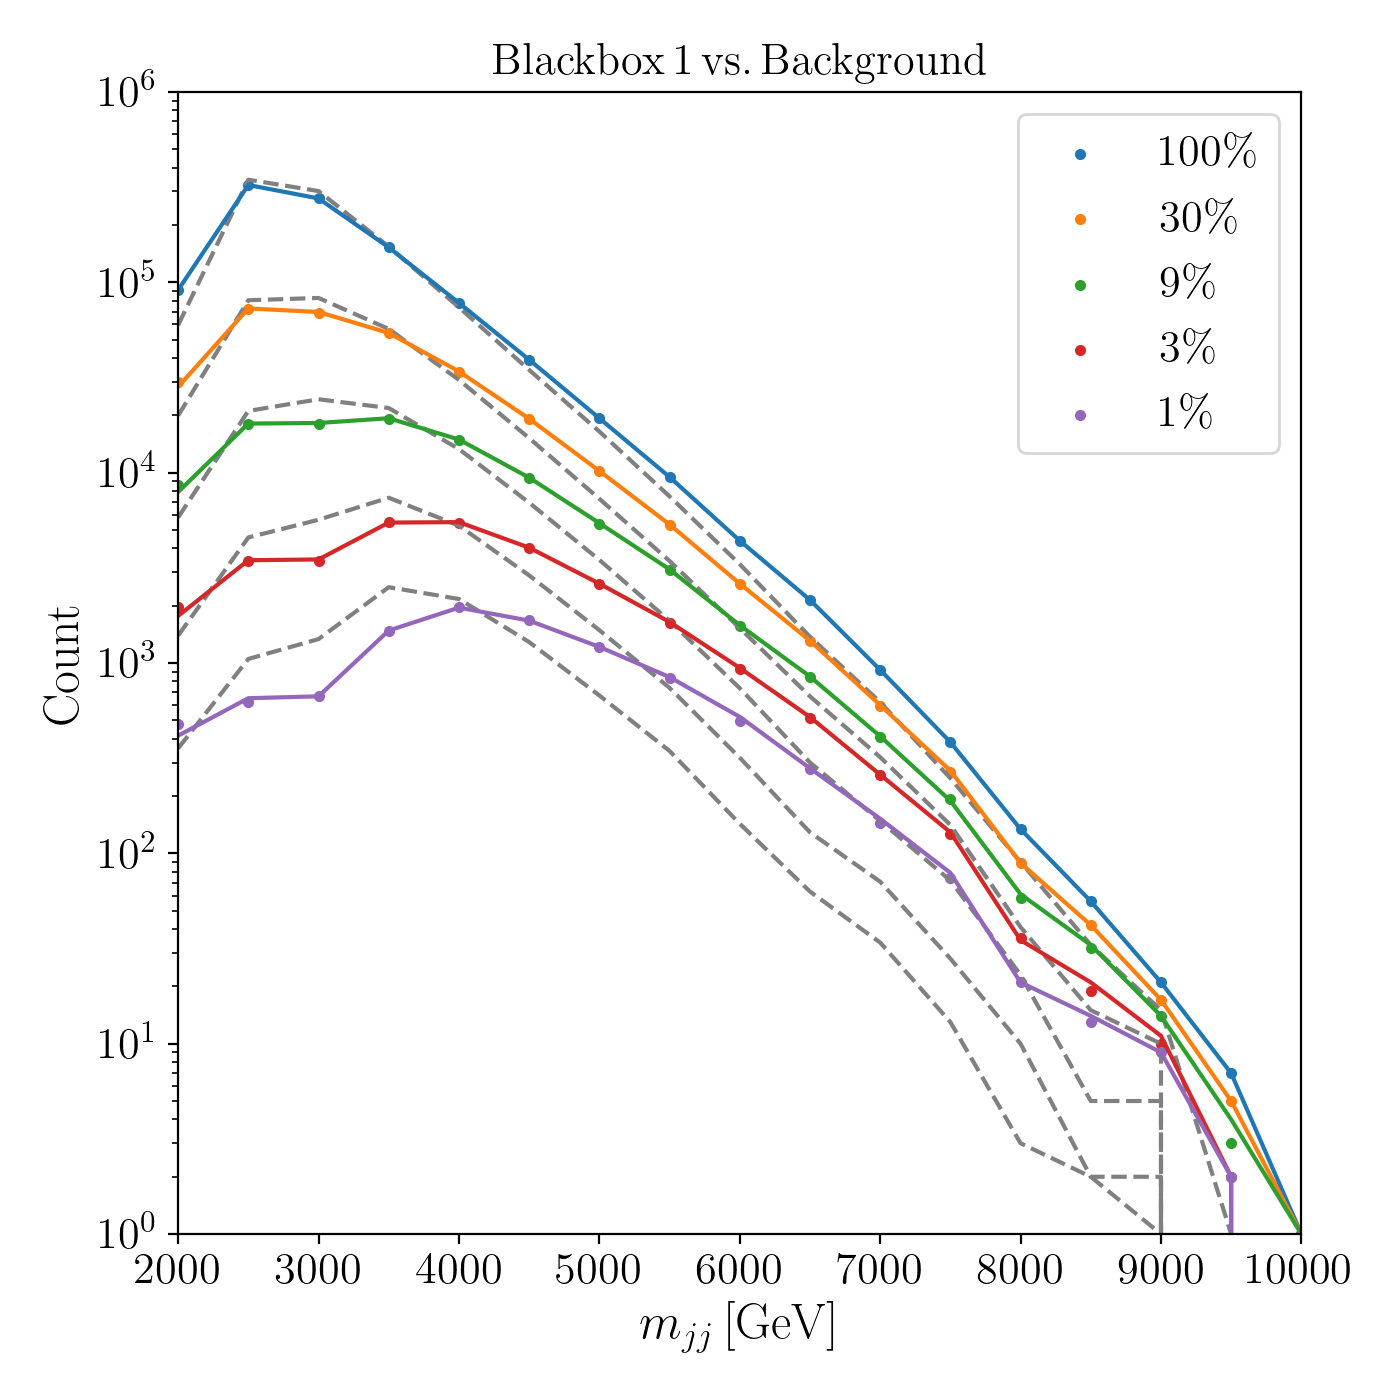

In [16]:
plt.figure(1, figsize=(7, 7))

for hist in od_hist_bg:
    plt.plot(utils.bin_means(hist[1]), hist[0], c='gray', ls='--')
for hist in od_hist_1bg:
    plt.plot(utils.bin_means(hist[1]), hist[0])
for i, hist in enumerate(od_hist_1):
    plt.scatter(utils.bin_means(hist[1]), hist[0], marker='.', label=r'${}\%$'.format(int(100*(1-od_quantiles[i]))))

plt.xlim(2000, 10000)
plt.ylim(10**0, 10**6)
plt.yscale('log')
plt.xlabel(r'$m_{jj}\, \rm [GeV]$')
plt.ylabel(r'$\rm Count $')
plt.title(r'$\rm Blackbox\, 1\, vs.\, Background$')
plt.legend()

plt.tight_layout(True)
plt.savefig(os.path.join(image_dir, 'blackbox1_outlier_detection.png'))
plt.show()

Either the predicted shape of QCD is not correct, or there is some BSM physics in the tail, or both! Let's try adjusting the shape of the background

<IPython.core.display.Javascript object>


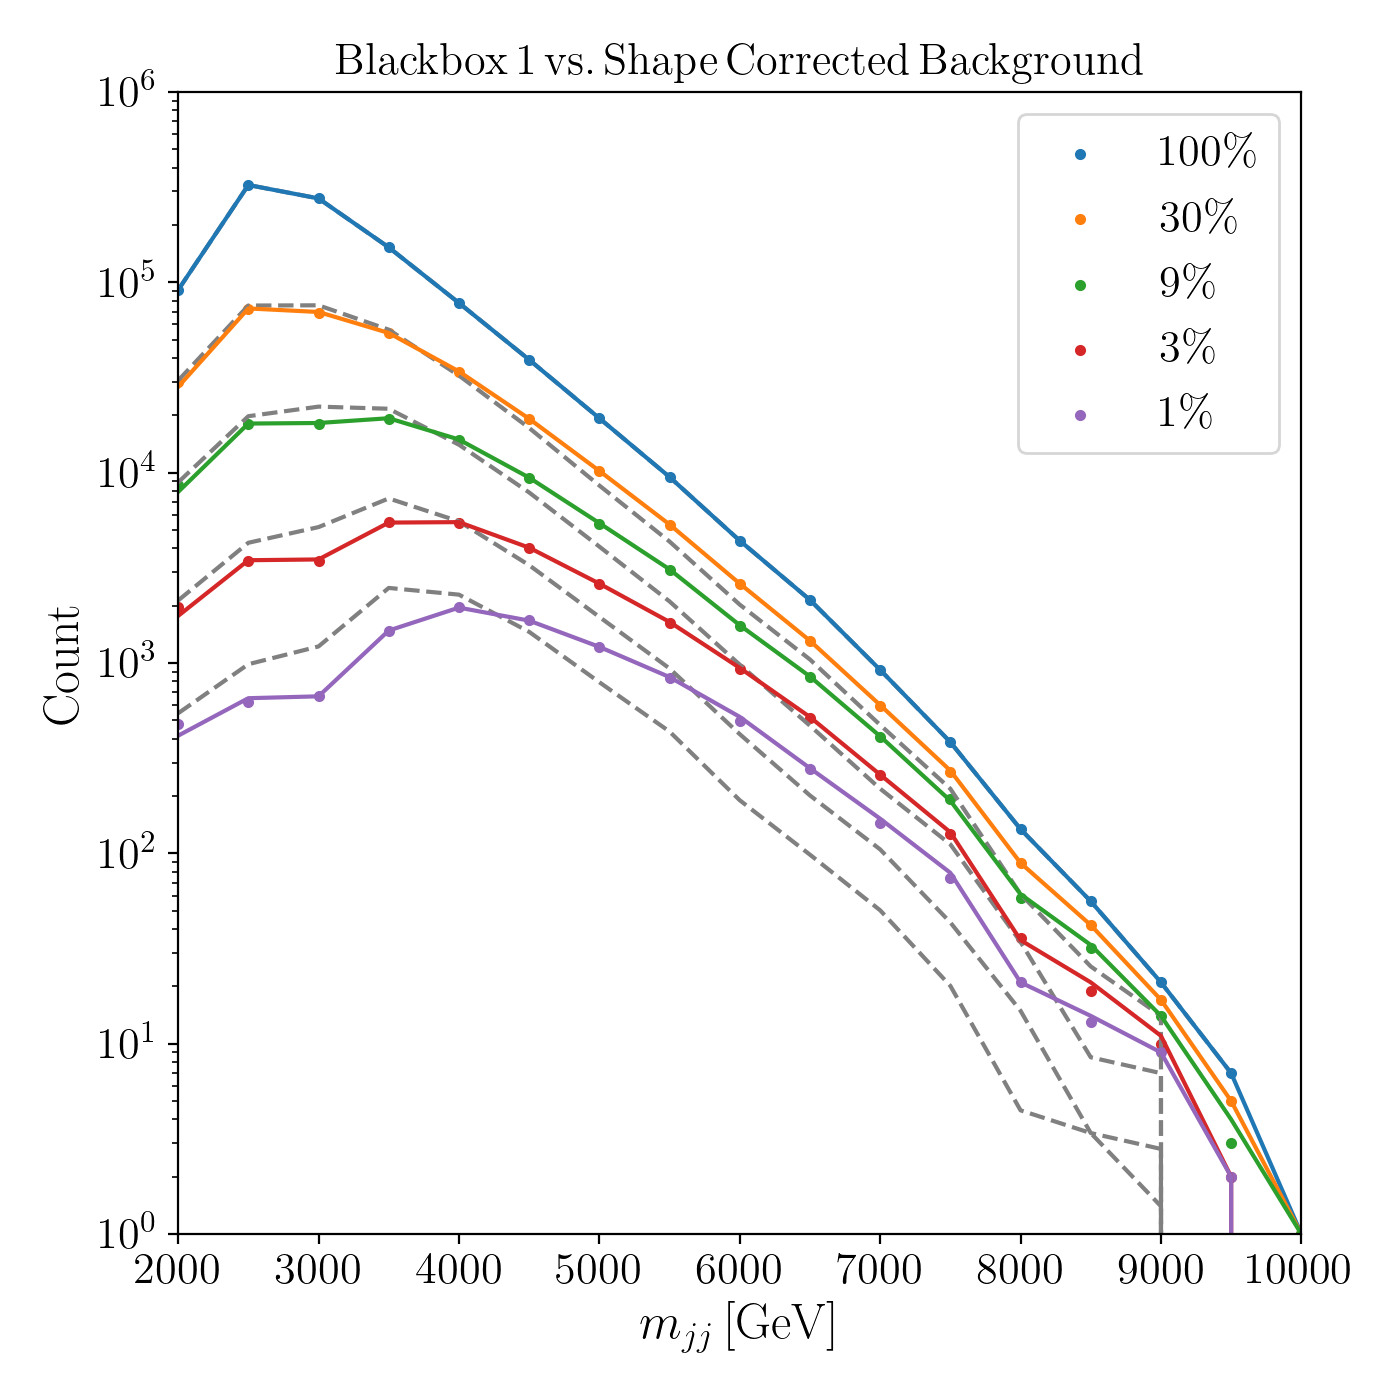

/Users/christopherwmurphy/venvs/lhc_olympics/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [17]:
plt.figure(2, figsize=(7, 7))

for hist in od_hist_bg:
    plt.plot(utils.bin_means(hist[1]), hist[0] * od_hist_1[0][0] / od_hist_bg[0][0], c='gray', ls='--')
for hist in od_hist_1bg:
    plt.plot(utils.bin_means(hist[1]), hist[0])
for i, hist in enumerate(od_hist_1):
    plt.scatter(utils.bin_means(hist[1]), hist[0], marker='.', label=r'${}\%$'.format(int(100*(1-od_quantiles[i]))))

plt.xlim(2000, 10000)
plt.ylim(10**0, 10**6)
plt.yscale('log')
plt.xlabel(r'$m_{jj}\, \rm [GeV]$')
plt.ylabel(r'$\rm Count $')
plt.title(r'$\rm Blackbox\, 1\, vs.\, Shape\, Corrected\, Background$')
plt.legend()

plt.tight_layout(True)
plt.show()

There is still an excess. Subtract the background

<IPython.core.display.Javascript object>


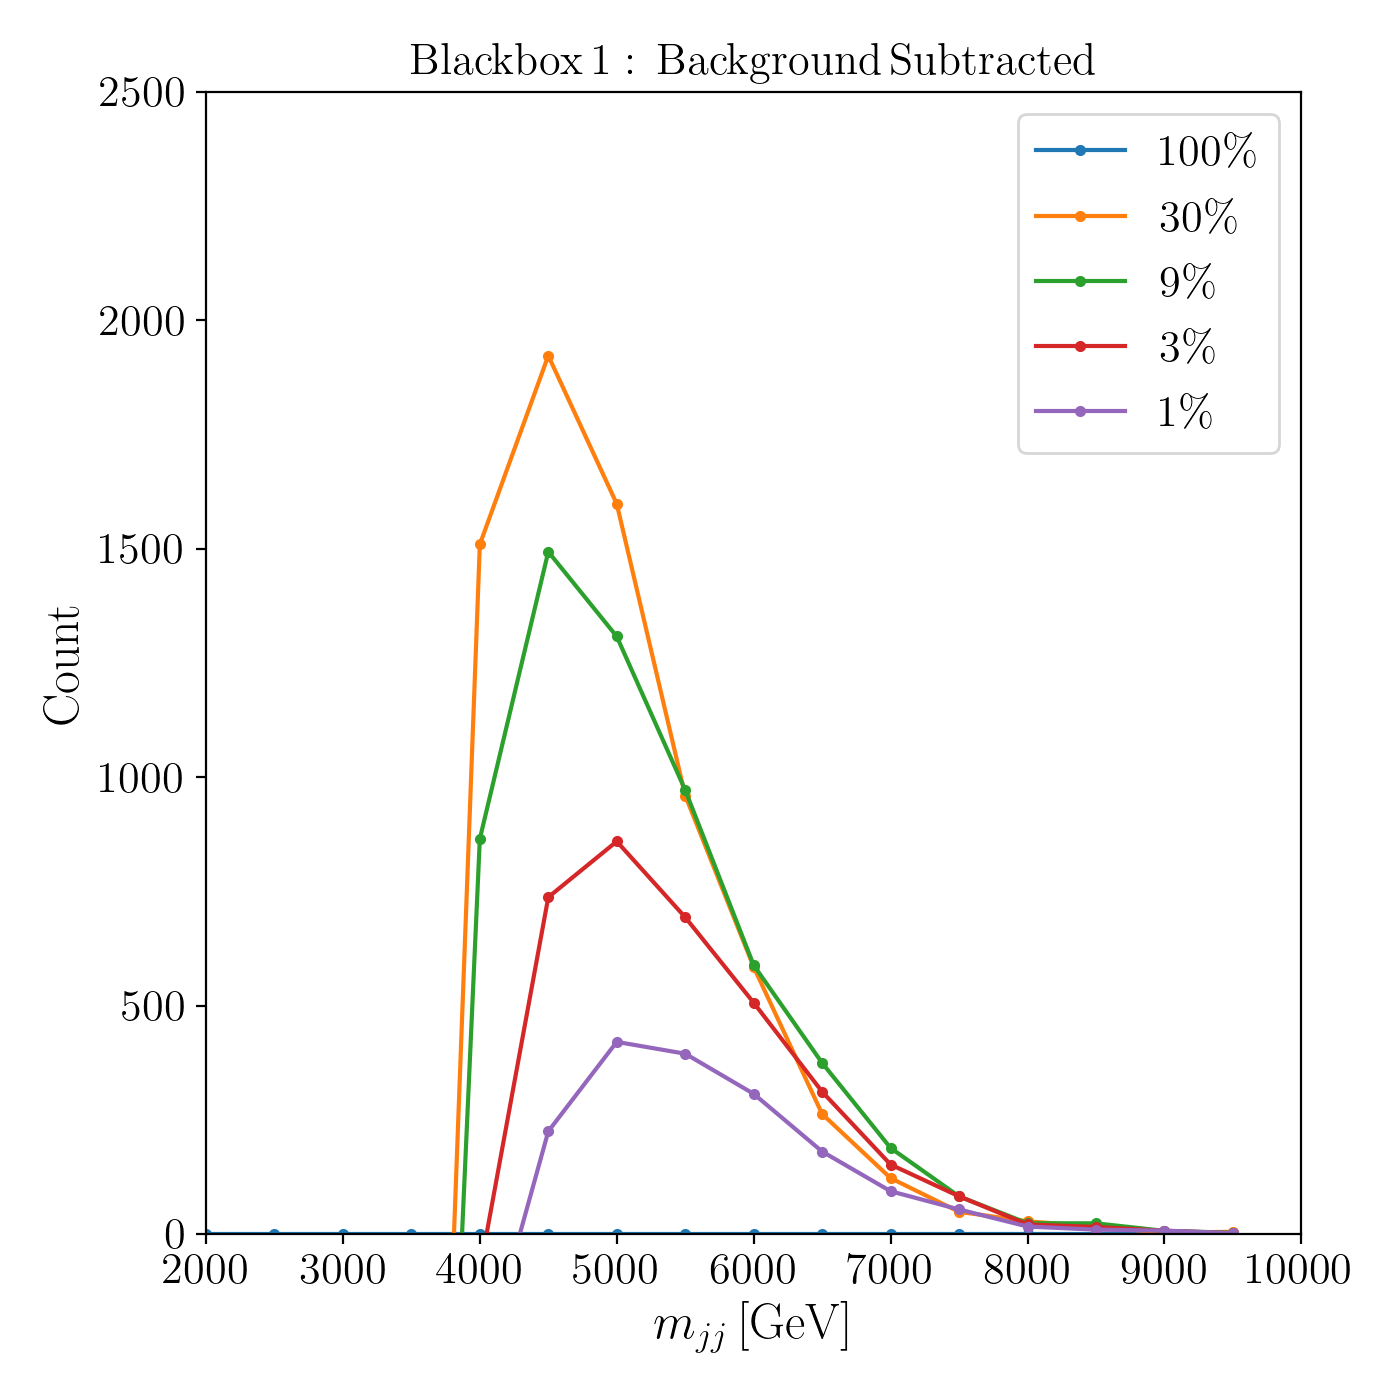

/Users/christopherwmurphy/venvs/lhc_olympics/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [18]:
plt.figure(3, figsize=(7, 7))

for i, hist in enumerate(od_hist_1):
    plt.plot(utils.bin_means(hist[1]), hist[0] - od_hist_bg[i][0] * od_hist_1[0][0] / od_hist_bg[0][0], 
             marker='.', label=r'${}\%$'.format(int(100*(1-od_quantiles[i]))))

plt.xlim(2000, 10000)
plt.ylim(0, 2500)
plt.xlabel(r'$m_{jj}\, \rm [GeV]$')
plt.ylabel(r'$\rm Count $')
plt.title(r'$\rm Blackbox\, 1:\, Background\, Subtracted$')
plt.legend()
plt.tight_layout(True)
plt.show()

# KPIs

## A p-value associated with the dataset having no new particles

Take the signal region to be 4000-6000 GeV. Use the 30% most outlying events in the signal region as the number of observed events, and the 30% most outlying events in signal region from the QCD dataset with shape adjustment as the number of expected events.

In [19]:
from src.analysis.discovery import compute_p_value

In [20]:
sb_idx_min, sb_idx_max = utils.get_sideband_indices(od_hist_1[0], 4000, 6000)

In [21]:
observed = np.sum(od_hist_1[1][0][sb_idx_min:sb_idx_max+1])
expected = np.sum((od_hist_bg[1][0] * od_hist_1[0][0] / od_hist_bg[0][0])[sb_idx_min:sb_idx_max+1])

/Users/christopherwmurphy/venvs/lhc_olympics/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [22]:
num_nuis_arr_init = [0.02]
num_bounds = [[-8 * np.sqrt(od_hist_1[1][0][5]), 8 * np.sqrt(od_hist_1[1][0][5])]]
den_nuis_arr_init = [0.01, 1.]

pval_kwargs = {
    'num_nuis_arr_init': num_nuis_arr_init, 
    'num_bounds': num_bounds, 
    'den_nuis_arr_init': den_nuis_arr_init, 
    'verbose': True
}

In [23]:
compute_p_value(observed, expected, **pval_kwargs)

INFO:root:Numerator:
INFO:root:fun = -721854.5281603809
INFO:root:jac = [0.]
INFO:root:nfev = 8
INFO:root:nit = 2
INFO:root:status = 0
INFO:root:message = b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
INFO:root:x = [0.10193849]
INFO:root:success = True
INFO:root:hess_inv = <1x1 LbfgsInvHessProduct with dtype=float64>
INFO:root:Denominator:
INFO:root:fun = -722179.0120844296
INFO:root:jac = [0. 0.]
INFO:root:hess_inv = [[ 0.87253531 -0.52275784]
 [-0.52275784  3.49019196]]
INFO:root:nfev = 100
INFO:root:njev = 25
INFO:root:status = 0
INFO:root:success = True
INFO:root:message = Optimization terminated successfully.
INFO:root:x = [1.31257892e-03 6.67943154e+03]
INFO:root:nit = 21


(0.0, 25.474847361612195)

$25\sigma$ seems unlikely...

## How many signal events are in the dataset

In [24]:
observed - expected

6574.550229543514

## Description of new particles: mass, decay modes, ...

In [25]:
from scipy.signal import peak_widths

In [26]:
observed_array = od_hist_1[1][0][sb_idx_min-1:sb_idx_max+2]
expected_array = (od_hist_bg[1][0] * od_hist_1[0][0] / od_hist_bg[0][0])[sb_idx_min-1:sb_idx_max+2]

/Users/christopherwmurphy/venvs/lhc_olympics/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [27]:
peak_widths(observed_array - expected_array, [2])

(array([2.89601253]),
 array([1092.74471581]),
 array([0.89572874]),
 array([3.79174127]))

Full width at half maximum

In [28]:
2.896 * 500

1448.0

Left interpolation point

In [29]:
(0.896 - 2)*500 + 4500

3948.0

Right interpolation point

In [30]:
(3.792 - 2)*500 + 4500

5396.0

# Post-dictions

The results of the 1st BlackBox challenged were [revealed](https://docs.google.com/presentation/d/17QI3nUf0QZiRDxHs_2kJkUB5PtT55DZVwr4Y449654A/edit#slide=id.g6db008d9b0_3_0). The mass of the $Z^{\prime}$ was just outside of my left inerpolation point for my FWHM. In short, this method didn't work too well. But, now that I have additional info, can it do any better?

Box 1:
- Signal: 834 events
- $Z^{\prime} \to X Y,\quad X, Y \to q q$ (same topology as R&D dataset)
- $m_{Z^{\prime}} = 3823$ GeV
- $m_X = 732$ GeV
- $m_y = 378$ GeV

In [10]:
qt1 = QuantileTransformer()
X_od1 = qt1.fit_transform(df_1[od_cols])
pca_1 = PCA(n_components=11, n_selected_components=1)
pca_1.fit(X_od1)
df_1['pca'] = pca_1.decision_scores_

In [11]:
qt_bg = QuantileTransformer()
X_od_bg = qt_bg.fit_transform(df_bg[od_cols])
pca_bg = PCA(n_components=11, n_selected_components=1)
pca_bg.fit(X_od_bg)
df_1['pca_bg'] = pca_bg.decision_function(X_od1)
df_bg['pca'] = pca_bg.decision_scores_

In [12]:
od_hist_bins = np.arange(3823 - 75*10.5, 3823 + 75*11.5, 75)
od_quantiles = [0.0, 0.7, 0.9, 0.97, 0.99, 0.997, 0.999]

In [13]:
od_hist_1 = utils.get_histograms(df_1, od_hist_bins, quantiles=od_quantiles)
od_hist_1bg = utils.get_histograms(df_1, od_hist_bins, quantiles=od_quantiles, feature='pca_bg')
od_hist_bg = utils.get_histograms(df_bg, od_hist_bins, quantiles=od_quantiles)

Nothing too obvious in the original way I did things. It's a big strech to interpret the crossing of the colored lines and the gray lines near 3800 GeV as the interference between signal and background, which might not even have been simulated anyways

<IPython.core.display.Javascript object>


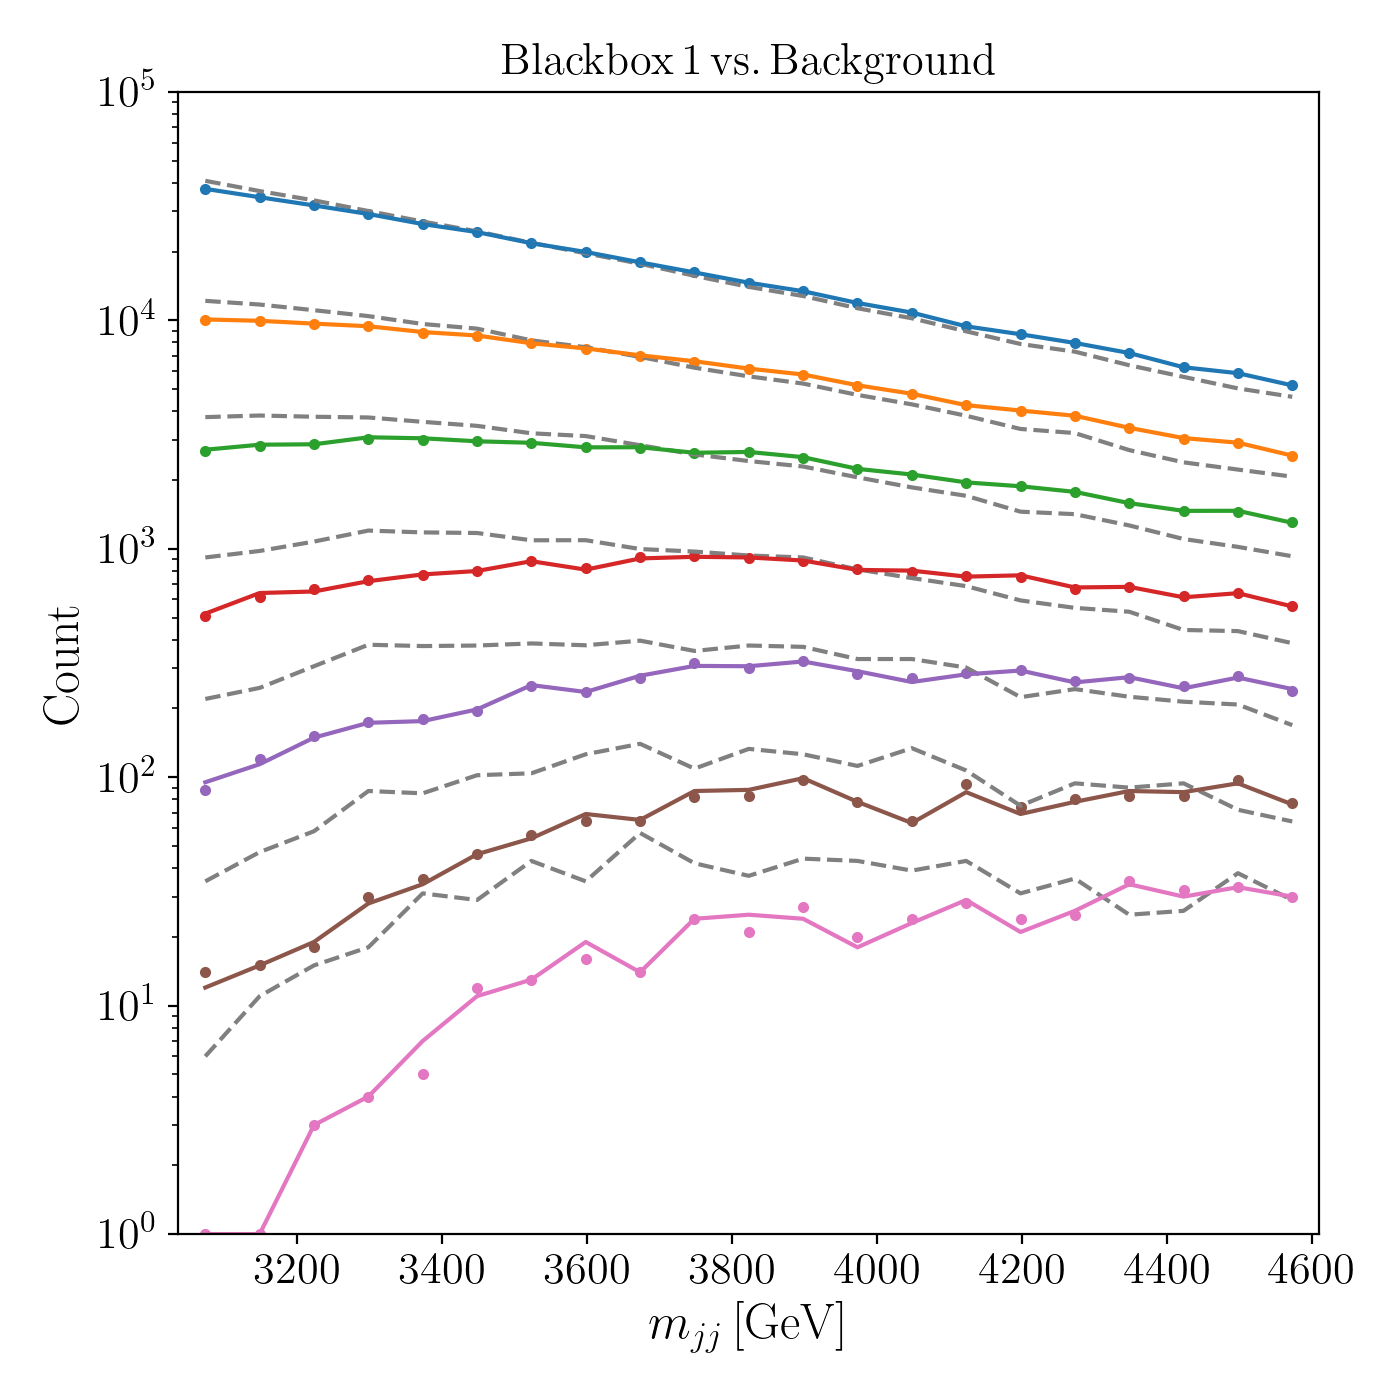

In [14]:
plt.figure(4, figsize=(7, 7))

for hist in od_hist_bg:
    plt.plot(utils.bin_means(hist[1]), hist[0], c='gray', ls='--')
for hist in od_hist_1bg:
    plt.plot(utils.bin_means(hist[1]), hist[0])
for i, hist in enumerate(od_hist_1):
    plt.scatter(utils.bin_means(hist[1]), hist[0], marker='.')

plt.xlim(3823 - 75*10.5, 3823 + 75*10.5)
plt.ylim(10**0, 10**5)
plt.yscale('log')
plt.xlabel(r'$m_{jj}\, \rm [GeV]$')
plt.ylabel(r'$\rm Count $')
plt.title(r'$\rm Blackbox\, 1\, vs.\, Background$')

plt.tight_layout(True)
plt.show()

Restrict to the region around the resonance

In [15]:
df_1c = df_1[(df_1['mass_jj'] > 3260.5) & 
             (df_1['mass_jj'] < 4385.5) & 
             (df_1['mass_1+mass_2'] > 950) & 
             (df_1['mass_1+mass_2'] < 1250) & 
             (df_1['|mass_1-mass_2|'] > 200) & 
             (df_1['|mass_1-mass_2|'] < 500)].copy().drop(columns=['pca', 'pca_bg'])
df_bgc = df_bg[(df_bg['mass_jj'] > 3260.5) & 
               (df_bg['mass_jj'] < 4385.5) & 
               (df_bg['mass_1+mass_2'] > 950) & 
               (df_bg['mass_1+mass_2'] < 1250) & 
               (df_bg['|mass_1-mass_2|'] > 200) & 
               (df_bg['|mass_1-mass_2|'] < 500)].copy().drop(columns=['pca'])

In [16]:
qt1 = QuantileTransformer()
X_od1 = qt1.fit_transform(df_1c[od_cols])
pca_1 = PCA(n_components=11, n_selected_components=1)
pca_1.fit(X_od1)
df_1c['pca'] = pca_1.decision_scores_

In [17]:
qt_bg = QuantileTransformer()
X_od_bg = qt_bg.fit_transform(df_bgc[od_cols])
pca_bg = PCA(n_components=11, n_selected_components=1)
pca_bg.fit(X_od_bg)
df_1c['pca_bg'] = pca_bg.decision_function(X_od1)
df_bgc['pca'] = pca_bg.decision_scores_

In [21]:
od_quantiles = [0.0, 0.7, 0.9, 0.97, 0.99, 0.997]

In [22]:
od_hist_1 = utils.get_histograms(df_1c, od_hist_bins, quantiles=od_quantiles)
od_hist_1bg = utils.get_histograms(df_1c, od_hist_bins, quantiles=od_quantiles, feature='pca_bg')
od_hist_bg = utils.get_histograms(df_bgc, od_hist_bins, quantiles=od_quantiles)

Still hard to say anything is there

<IPython.core.display.Javascript object>


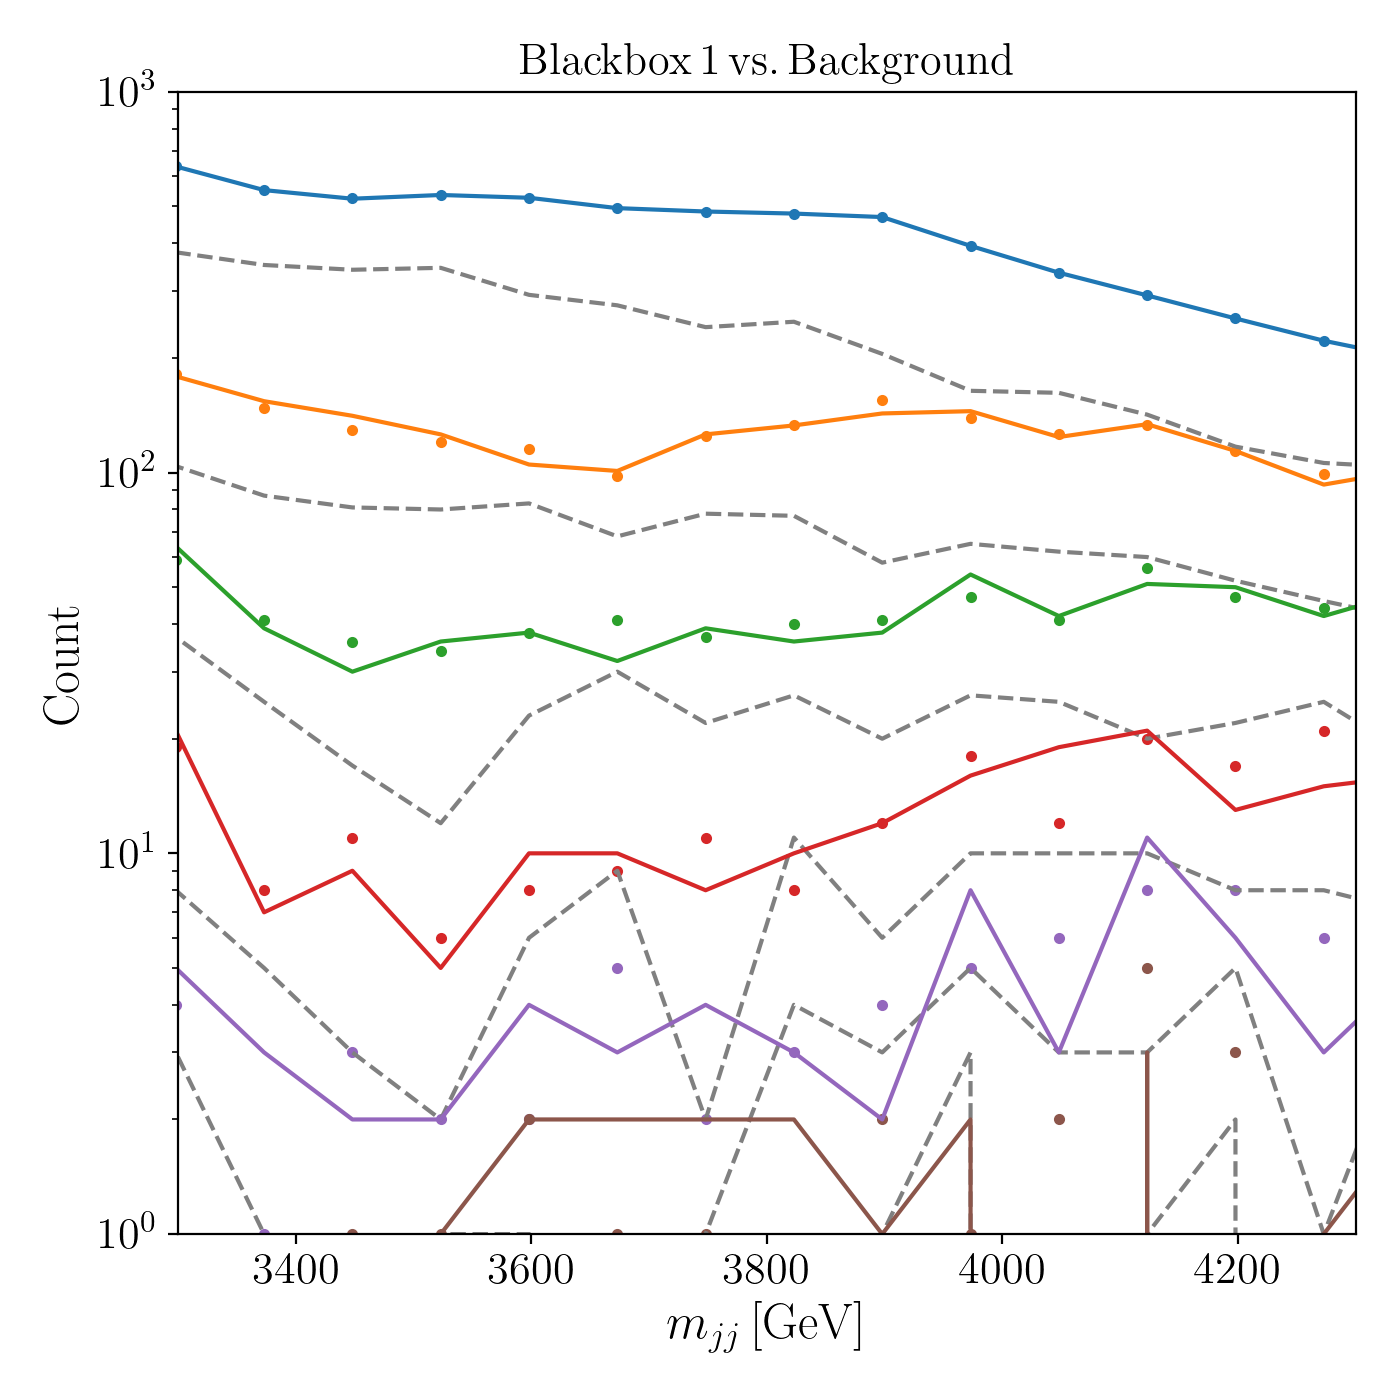

In [23]:
plt.figure(5, figsize=(7, 7))

for hist in od_hist_bg:
    plt.plot(utils.bin_means(hist[1]), hist[0], c='gray', ls='--')
for hist in od_hist_1bg:
    plt.plot(utils.bin_means(hist[1]), hist[0])
for i, hist in enumerate(od_hist_1):
    plt.scatter(utils.bin_means(hist[1]), hist[0], marker='.')

plt.xlim(3300, 4300)
plt.ylim(10**0, 10**3)
plt.yscale('log')
plt.xlabel(r'$m_{jj}\, \rm [GeV]$')
plt.ylabel(r'$\rm Count $')
plt.title(r'$\rm Blackbox\, 1\, vs.\, Background$')

plt.tight_layout(True)
plt.show()

Let's try CWoLa w/ XGBoost

In [24]:
from src.analysis import cwola_hunting
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

In [27]:
cwola_hist = cwola_hunting.cwola_hunting(
    df_1, 
    XGBClassifier(tree_method='hist'), 
    StratifiedKFold(n_splits=5), 
    3823 - 450, 
    3823 + 450, 
    3823 - 225, 
    3823 + 225, 
    feature_cols=od_cols, 
    transformer=QuantileTransformer(), 
    bin_width=75,
    clf_quantiles=[0.1, 0.7, 0.9]
)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [64]:
def cwola_hunting2(df, classifier, spliter, sideband_min, sideband_max, signal_region_min, signal_region_max, feature_cols=None, transformer=None, bin_width=50, clf_quantiles=[0.0, 0.7, 0.9]):
    sideband_region = (df['mass_jj'] > sideband_min-bin_width/2) & (df['mass_jj'] < sideband_max+bin_width/2)
    df_cwola = df[sideband_region].copy().dropna().reset_index(drop=True)
    signal_region = (df_cwola['mass_jj'] > signal_region_min) & (df_cwola['mass_jj'] < signal_region_max)
    df_cwola['signal_region'] = signal_region.astype('int64')
    print(df_cwola['signal_region'][:10])

    if feature_cols is None:
        feature_cols = df.columns.drop(['mass_jj'])
    X = df_cwola[feature_cols]
    y = df_cwola['signal_region']

    df_clf = pd.DataFrame(columns=['index', 'xgb_score'])
    for tr_idx, te_idx in spliter.split(X, y):
        if transformer is not None:
            trans = transformer
            X_tr = trans.fit_transform(X.iloc[tr_idx])
            X_te = trans.transform(X.iloc[te_idx])
        else:
            X_tr = X.iloc[tr_idx]
            X_te = X.iloc[te_idx]
        y_tr = y.iloc[tr_idx]
        y_te = y.iloc[te_idx]

        clf = classifier
        clf.fit(X_tr, y_tr)
        df_clf = df_clf.append(pd.DataFrame(data={'index': te_idx, 'score': clf.predict_proba(X_te).T[1]}))

    df_te = df_cwola[['mass_jj']].merge(df_clf, how='left', left_index=True, right_on='index').drop(columns=['index'])
    clf_hist_bins = np.arange(sideband_min-bin_width/2, sideband_max+3*bin_width/2, bin_width)
    return df_te

In [65]:
cwola_hunting2(
    df_1, 
    XGBClassifier(tree_method='hist'), 
    StratifiedKFold(n_splits=5), 
    3823 - 450, 
    3823 + 450, 
    3823 - 225, 
    3823 + 225, 
    feature_cols=od_cols, 
    transformer=QuantileTransformer(), 
    bin_width=75,
    clf_quantiles=[0.1, 0.7, 0.9]
)

0    0
1    1
2    0
3    0
4    0
5    0
6    1
7    1
8    0
9    1
Name: signal_region, dtype: int64
203300
0    0
1    1
2    0
3    0
4    0
5    0
6    1
7    1
8    0
9    1
Name: signal_region, dtype: int64
203300
0


/Users/christopherwmurphy/venvs/lhc_olympics/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/Users/christopherwmurphy/venvs/lhc_olympics/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/Users/christopherwmurphy/venvs/lhc_olympics/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

,mass_jj,score,xgb_score
0,3343.705821,0.352150,NaN
1,3735.583296,0.413145,NaN
2,3474.245902,0.551390,NaN
3,3456.038220,0.361184,NaN
4,4132.580084,0.365961,NaN
...,...,...,...
40655,3697.283622,0.548450,NaN
40656,3776.912630,0.416304,NaN
40657,3422.713952,0.365904,NaN
40658,4086.656892,0.765070,NaN
